In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# Set our secret string to ‘011’
shh = '011'

# Creating registers
# Set the input qubit register size equal to the length of s
input_qubits = len(str(shh))
# Set the total qubits equal to twice the size of input qubits
total_qubits = 2*input_qubits

# Create the quantum circuit
qc = QuantumCircuit(total_qubits)

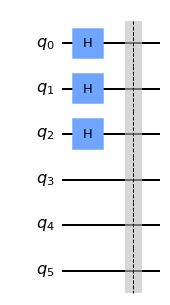

In [3]:
# Apply Hadamard gates before querying the oracle
qc.h(range(input_qubits)) 
qc.barrier()
qc.draw()

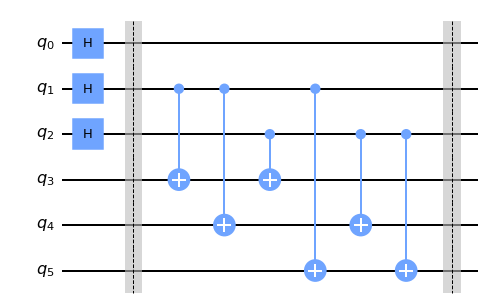

In [4]:
# Create the oracle function of our secret string 
# Since we are only setting the last two qubits, 
# we will only apply cx gates to the last two. 
for idx in range(input_qubits):
    if(shh[idx] == '1'):
        for count in range(input_qubits):
            qc.cx(idx, input_qubits + count)

qc.barrier()
qc.draw()

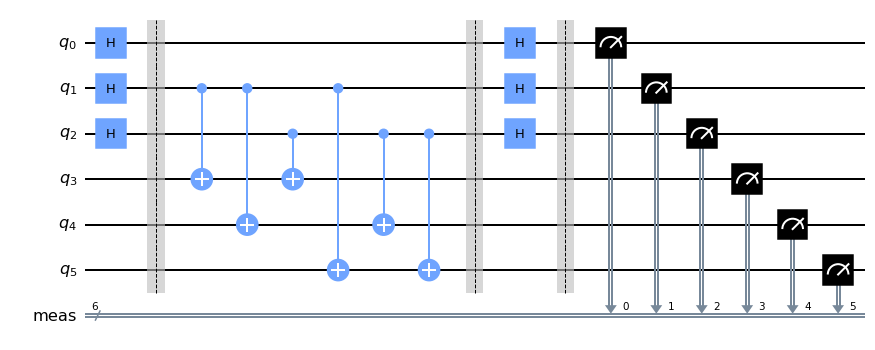

In [5]:
# Apply Hadamard gates to the input register
qc.h(range(len(str(shh))))

# Measure ancilla qubits
qc.measure_all()
qc.draw()

In [6]:
# Execute the quantum circuit on the simulator
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
counts = results.get_counts(qc)

# Print results
print('Counts: ', counts)

Counts:  {'111000': 295, '111110': 261, '000110': 242, '000000': 226}


sub results {'000': 521, '110': 503}


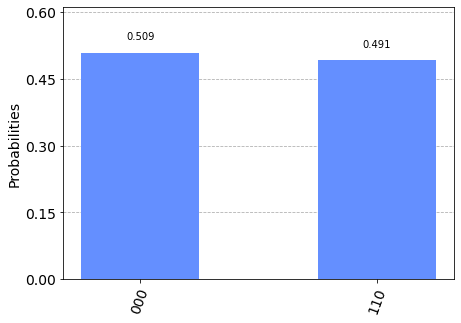

In [7]:
# Create a new object to store the input register counts
sub_results = {}
# Loop through each of the count keys and extract the 
# the input register and their respective counts. 
for count in counts.keys():
    rev_count_key = count[::-1]
    input_count = count[input_qubits:]
    count_value = counts[count]
    if input_count in sub_results:
        sub_results[input_count] += count_value
    else:
        sub_results[input_count] = count_value

# Print and plot the results
print('sub results', sub_results)
plot_histogram(sub_results)

In [8]:
# Initialize the 3-qubit quantum circuit
# Set the state '110'
s = '110'
num_qubits = len(s)
qc = QuantumCircuit(num_qubits)

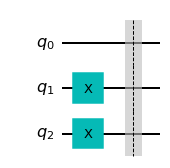

In [9]:
# Set reverse ordering
s = s[::-1] 

# Construct the state 110
for idx in range(num_qubits):
    if s[idx] == '1':
        qc.x(idx)    

qc.barrier()
qc.draw()

In [10]:
# Import the value pi for our rotations
from numpy import pi

# Always start from the most significant qubit, 
# in this case it's q2.
# Step 1, add a Hadamard gate
qc.h(2)

In [11]:
# Step 2, add CROT gates from most significant qubit 
qc.cu1(pi/2, 1, 2)

/tmp/ipykernel_4978/289640335.py:2: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/2, 1, 2)


/tmp/ipykernel_4978/3362646133.py:3: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/4, 0, 2)


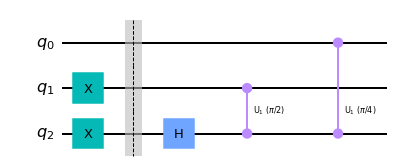

In [12]:
# Step 3, add another CROT from 2 to the next qubit down,
# while doubling the phase denominator
qc.cu1(pi/4, 0, 2)

# Draw the circuit
qc.draw()

In [13]:
# Now that we finished from 2 down to 0
# We'll drop to the next least significant qubit and start again, 
# Step 1, add a Hadamard gate
qc.h(1)

/tmp/ipykernel_4978/1836114679.py:4: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/2, 0, 1)


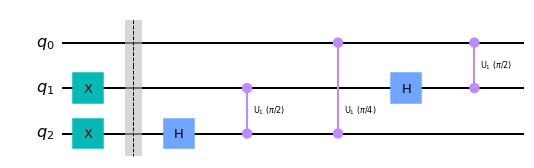

In [14]:
# Step 2, add Control Rotation (CROT) gates from most significant towards 
# least significant starting a pi/2, and doubling the denominator 
# as you go down each qubit. 
qc.cu1(pi/2, 0, 1)

# Draw the circuit
qc.draw()

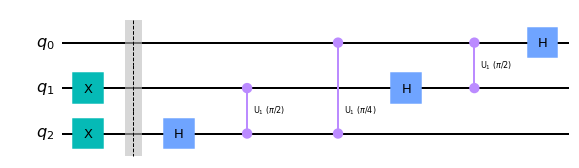

In [15]:
# Step 1, add a Hadamard gate
qc.h(0)
# Since we are at the least significant qubit, we are done!

# Draw the circuit
qc.draw()

In [16]:
# Define a function which will add the swap gates to the outer 
# pair of qubits
def add_swap_gates(qc_swaps, qubits):
    for qubit in range(qubits//2):
        qc_swaps.swap(qubit, qubits-qubit-1)
    return qc_swaps

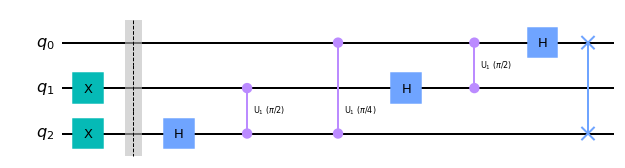

In [17]:
qft_circuit = add_swap_gates(qc, num_qubits)
qft_circuit.draw()

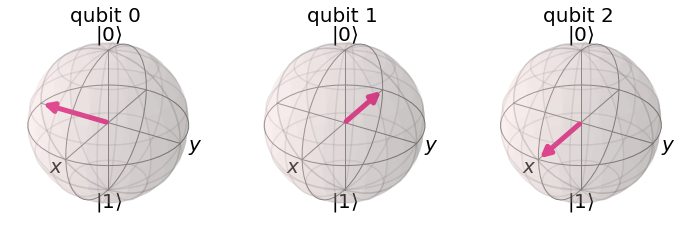

In [18]:
# Get the state vector simulator to view our final QFT state
backend = Aer.get_backend("statevector_simulator")

# Execute the QFT circuit and visualize the results
statevector = execute(qft_circuit,       
                   backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

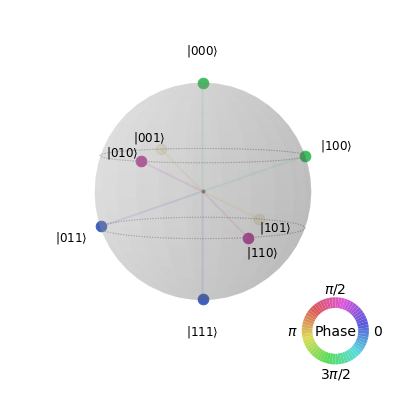

In [19]:
plot_state_qsphere(statevector)

# **Grover's Algorithm**
Implementing Grover's algorithm

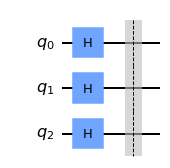

In [27]:
# Set the state we wish to search 
N = '110'
num_qubits = len(N)

# Create the quantum circuit 
qc = QuantumCircuit(num_qubits)

# Set all qubits in superposition
qc.h(range(num_qubits))
qc.barrier()

#Draw the circuit
qc.draw()


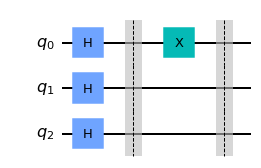

In [28]:
# Reverse the state so it’s in proper qubit ordering
N = N[::-1]

# Encode N into our circuit
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw()

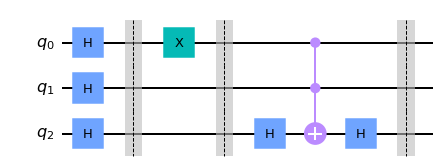

In [29]:
# Create the Grover oracle for our 3-qubit quantum circuit
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw()

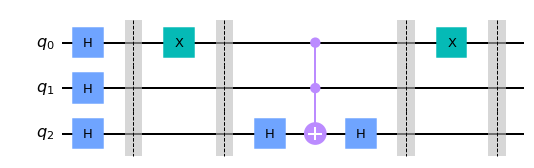

In [30]:
# Reset the value after the oracle
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw()

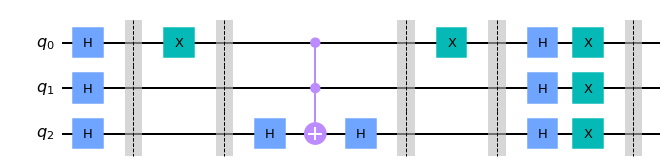

In [31]:
# Set all qubits in superposition
qc.h(range(num_qubits))
qc.x(range(num_qubits))
qc.barrier()

# Draw the circuit
qc.draw()

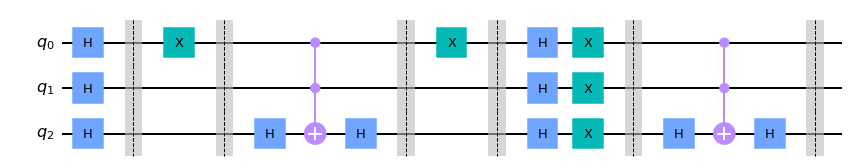

In [32]:
# Apply another oracle, same as the previous, 
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw()

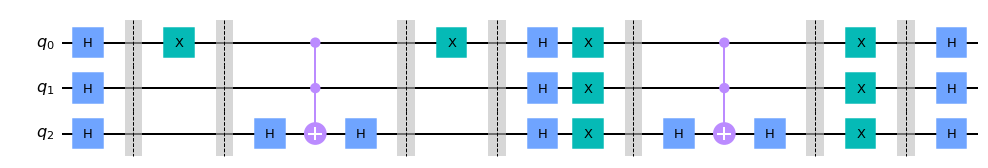

In [33]:
# Reapply the X rotations on all qubits
qc.x(range(num_qubits))

qc.barrier()

# Reapply Hadamard gates to all qubits
qc.h(range(num_qubits))

# Draw the circuit
qc.draw()

In [34]:
# Add measurement operators
qc.measure_all()

# Draw the circuit
qc.draw()

# Run on the qasm simulator
backend = Aer.get_backend('qasm_simulator')
# Execute the circuit on the backend
job = execute(qc, backend, shots=1024)

# Extract the results
results = job.result()
counts = results.get_counts(qc)

{'001': 23, '010': 34, '101': 37, '011': 26, '000': 36, '111': 37, '110': 799, '100': 32}


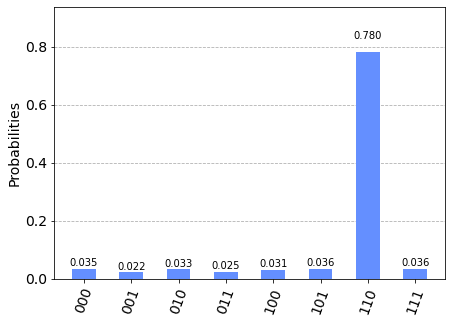

In [35]:
# Run on the qasm simulator
backend = Aer.get_backend('qasm_simulator')

# Execute the circuit on the backend
job = execute(qc, backend, shots=1024)

# Extract the results
results = job.result()
counts = results.get_counts(qc)

# Print and plot results
print(counts)
plot_histogram(counts)

## **Run Grover's algorithm on a quantum computer**

In [36]:
# Execute the circuit on the least busy quantum computer
from qiskit.providers.ibmq import least_busy

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (num_qubits) and
                                   not x.configuration().simulator and x.status().operational==True))
print("Set backend: ", backend)

# Launch the job watcher widget
%qiskit_job_watcher

Set backend:  ibmq_manila


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

{'000': 65, '001': 72, '010': 82, '011': 60, '100': 105, '101': 86, '110': 429, '111': 125}


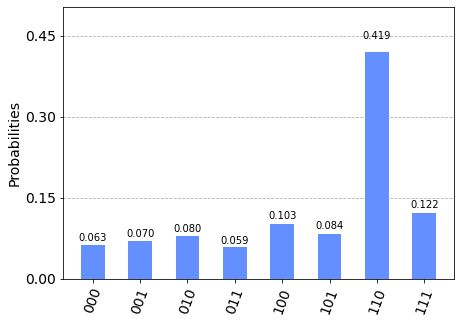

In [37]:
# Execute the circuit on the backend
job = execute(qc, backend, shots=1024)

# Extract the results
results = job.result()
counts = results.get_counts(qc)

# Print and plot results
print(counts)
plot_histogram(counts)

In [38]:
import qiskit.tools.jupyter
%qiskit_version_table